## Homework 2: K-L Expansions for the Exponential(Radial Basis Function Kernel)

In this assignment, our goal is to develop a K-L expansion based on the exponential kernel/autocorrelation function.

The eigenvalues and eigenfunctions are given by:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import optimize
from fractions import Fraction

np.set_printoptions(precision = 4)

def efunc(x,k,v_k,L=1):
    if k%2 == 0:
        return np.sin(v_k[k]*x)/np.sqrt(1-np.sin(2*v_k[k])/(2*v_k[k]))
    else:
        return np.cos(v_k[k]*x)/np.sqrt(1+np.sin(2*v_k[k])/(2*v_k[k]))

def eval(k,v_k,L=1,var_p=1):
    if k%2==0:
        return var_p*2*L/(1+L**2*v_k[k]**2)
    else:
        return var_p*2*L/(1+L**2*v_k[k]**2)

## What are the $w_k$ and the $v_k$?

They are the (numbered by $k$) solutions:
$$
\begin{array}{ll}
Lx+\tan(x) = 0 &  \quad k~\text{even} \\
1-Lx\tan(x) =0 & \quad k~\text{odd}
\end{array}
$$


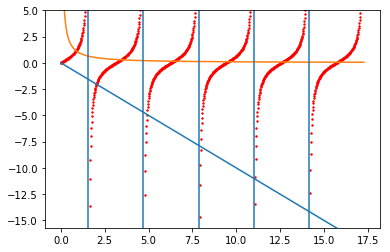

In [2]:
pts=np.linspace(1E-3,11*np.pi/2,1000)
plt.plot(pts, -pts)
plt.scatter(pts,np.tan(pts),c='r',s=2)
plt.plot(pts,1/pts)
plt.ylim([-10*np.pi/2,5])
for i in range(1,10,2):
    plt.axvline(i*np.pi/2)
plt.show()

### Problem 1

* Use a nonlinear solver(e.g. ) to determine the 
$w_k$ and $v_k$.  From the periodicity of $\tan x$ you can come up with good starting guesses for the method.
* Plot the first ten eigenvalues and eigenfunctions for $L=1$ for this kernel and plot the approximation of $c(x,y)$ versus $c(x,y)$.  Similar plots are in the Alexandrian notes and you can also find them on the internet.
* Plot a **realization** of the K-L expansions for $L=1,1/8,1/64$ using 10 and 40 terms respectively and comment on any differences you observe-use the same values of the random variables in the expansions for ease of comparison.

In [2]:
# generate solutions to transcendental equations and contruct v_k
def f1(x, L=1):
    return L*x + np.tan(x)

def f2(x, L=1):
    return 1 - L*x*np.tan(x)

def build_vk(k=40):
    vk=np.zeros(k+2)
    vk[1]=optimize.root_scalar(f2, bracket = [0,np.pi/2-1E-3], method ='brentq').root
    ind=1
    for i in range(1,k+1,2):
        interval=[i*np.pi/2+1E-3,i*np.pi/2+np.pi-1E-3]
        ind+=1
        vk[ind]=optimize.root_scalar(f1,bracket=interval, method='brentq').root
        ind+=1
        vk[ind]=optimize.root_scalar(f2,bracket=interval, method='brentq').root
    return vk

vk=build_vk()

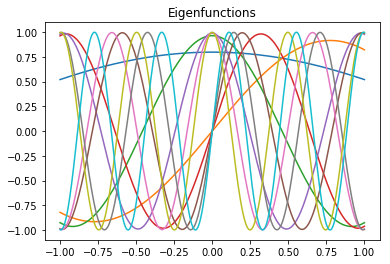

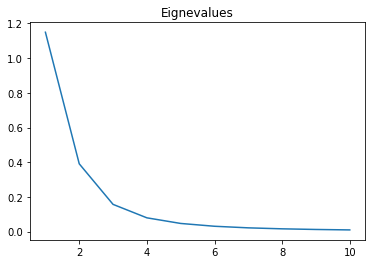

In [8]:
## Part 2
# plot eigenfunctions
t = np.linspace(-1, 1, 1000)

fig1 = plt.figure()
for k in range(1, 11):
    plt.plot(t, efunc(t, k, vk, L = 1))
plt.title('Eigenfunctions')
plt.show()

# plot eigenvalues
fig2 = plt.figure()
plt.plot(range(1, 11), [eval(k, vk, L = 1, var_p = 1) for k in range(1, 11)])
plt.title('Eignevalues')
plt.show()

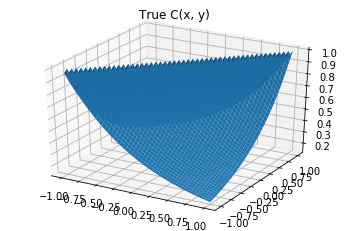

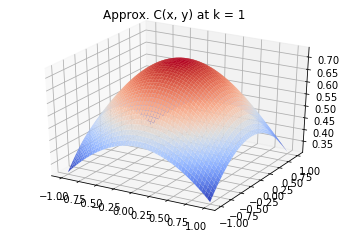

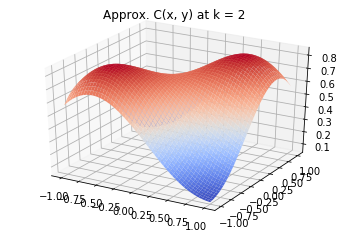

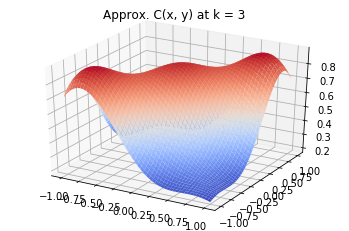

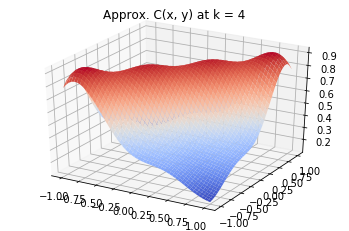

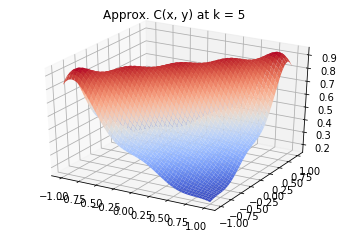

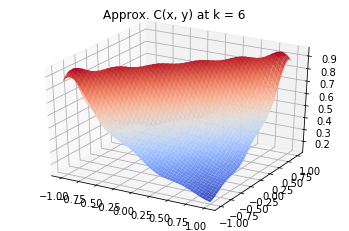

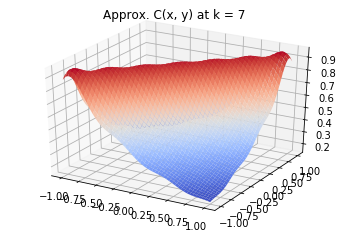

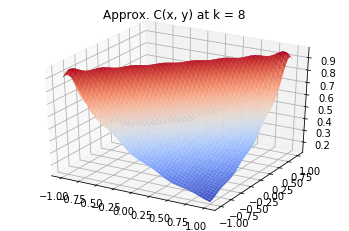

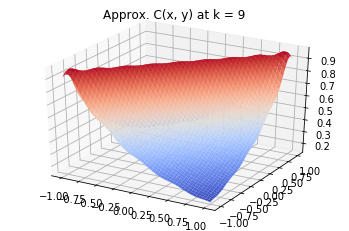

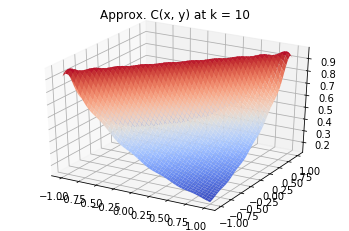

In [9]:
# Approximation of c(x, y) vs. c(x, y)
x, y = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
fig = plt.figure()
ax = fig.gca(projection = '3d')

L = 1
sigma_sq = 1
z = sigma_sq*np.exp(-abs(x - y)/L)
surf = ax.plot_surface(x, y, z)
plt.title("True C(x, y)")
plt.show()
    
z = np.zeros(x.shape)
for k in range(1, 11):
    fig = plt.figure()
    ax = fig.gca(projection = '3d')
    z += eval(k, vk, L = 1, var_p = 1)*efunc(x, k, vk, L)*efunc(y, k, vk, L)
    ax.plot_surface(x, y, z, cmap = cm.coolwarm)
    plt.title("Approx. C(x, y) at k = " + str(k))
    plt.show()

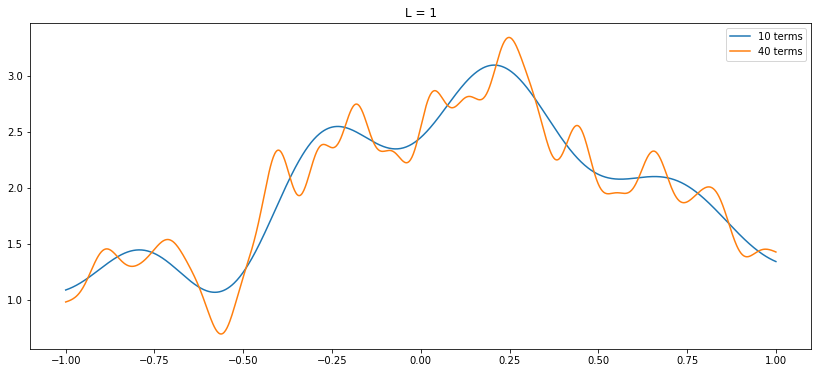

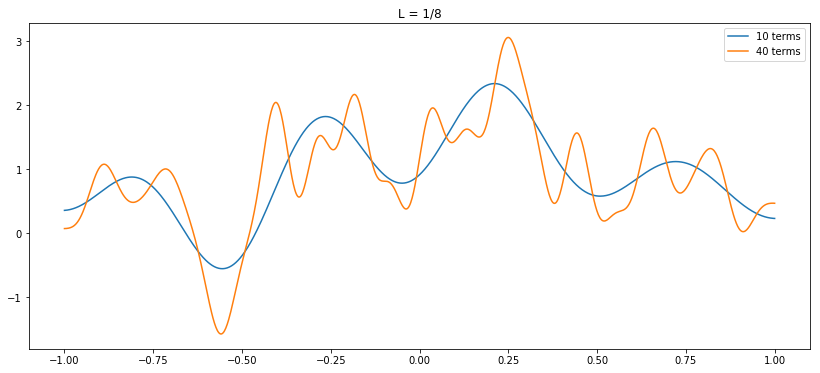

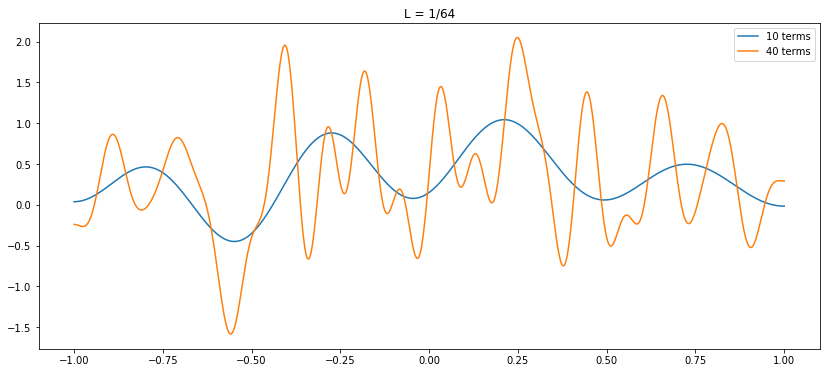

In [15]:
## Part 3
def realize1(x, k, L):
    vk=build_vk(k)
    out = np.zeros(x.shape)
    np.random.seed(101)
    rv = np.random.randn(40)
    
    for i in range(1, k+1):
        out += rv[i-1] * np.sqrt(eval(i, vk, L)) * efunc(x, i, vk, L)
        
    return out

t = np.linspace(-1, 1, 1000)

for L in [1, 1/8, 1/64]:
    plt.figure(figsize = (14, 6))
    for k in [10, 40]:
        plt.plot(t, realize1(t, k, L), label = str(k) + ' terms')
    plt.title('L = ' + str(Fraction(L)))
    plt.legend()
    plt.show()

### Problem 2

The growth rate for a bacterial colony is postulated to be a Gaussian process with mean 1 and unknown variance. Assuming a exponential autocorrelation function with unknown correlation length $L$:

* Pick your own true values of the variance and correlation length for the process and generate hourly data (e.g. $t=1/24,2/24$)  from a realization of the GP using 40 K-L terms. Use an initial population of 1000 bacteria and assume perfect measurements.
* Use this numerical data to try and reconstruct the true GP.


In [24]:
def realize2(x, k, L, mean, var_p):
    vk = build_vk(k)
    out = np.zeros(x.shape) + mean
    rv = np.random.randn(k)
    
    for i in range(1, k+1):
        out += rv[i-1] * np.sqrt(eval(i, vk, L, var_p)) * efunc(x, i, vk, L)
    
    return out

In [40]:
# i couldn't get this to work. i think it's an indexing issue that.

def pop_eval(x, k, L, mean, var_p):
    vk = build_vk(k)
    out = np.zeros(x.shape) + mean
    integ = np.zeros(x.shape)
    rv = np.random.randn(k)
    
    # these are the integrals of the eignefunctions
    for i in range(1, k+1):
        if i%2 == 0:
            integ += np.sqrt(1-np.sin(2*vk[i])/(2*vk[i]))*(-1/vk[i])*(np.cos(vk[i]*x)-1)
        else:
            integ += np.sqrt(1-np.sin(2*vk[i])/(2*vk[i]))*(1/vk[i])*(np.sin(vk[i]*x))
        
        out += rv[i-1] * np.sqrt(eval(i, vk, L, var_p)) * integ[i-1]
        
    return out

In [42]:
## Part 1
# realization for a single petri dish
pop = []
pop_init = 1000.
t = np.linspace(1/24, 1, 24)

a_t_omega = realize2(t, k = 40, L = 1, mean = 1, var_p = 1)
#pop = pop_init*np.exp(pop_eval(t, k = 40, L = 1, mean = 1, var_p = 1))
print('Growth Rate at Each Hour: ', a_t_omega)
#print('Population at Each Hour: ', pop)

Growth Rate at Each Hour:  [1.0334 1.1139 0.9326 0.7511 0.555  0.4702 0.7739 0.5783 0.0586 0.2976
 0.4544 0.2409 0.3534 0.3209 0.1388 0.2728 0.4645 0.5311 0.5098 0.3955
 0.2542 0.2013 0.2423 0.2872]


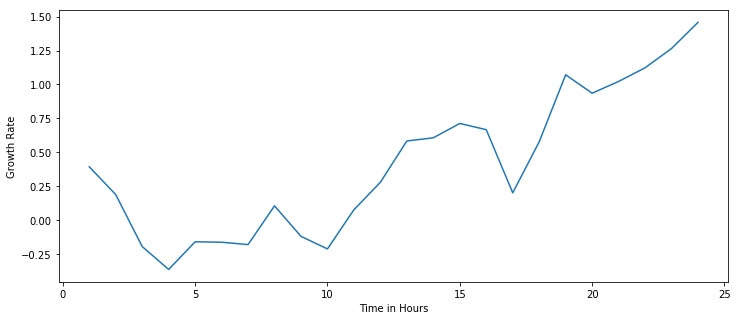

In [12]:
time = np.linspace(1, 24, 24)

plt.figure(figsize = (12, 5))
plt.plot(time, a_t_omega)
plt.xlabel('Time in Hours')
plt.ylabel('Growth Rate')
plt.show()

#plt.figure(figsize = (12, 5))
#plt.plot(time, pop)
#plt.title('Realized Population at Each Hour')
#plt.xlabel('Time in Hours')
#plt.ylabel('Population')
#plt.show()

In [9]:
## Part 2
# generate a matrix of growth rates and populations for each time increment
t = np.linspace(1/24, 1, 24)
Nmc = 100
alpha_mat = np.zeros(shape = (Nmc, len(t)))
pop_mat = np.zeros(shape = (Nmc, len(t)))
pop_init = 1000.
corr_func = np.zeros(shape = (len(t), len(t)))

for i in range(Nmc):
    alpha_mat[i] = realize2(t, k = 40, L = 1, mean = 1, var_p = 1)
    #pop_mat[i] = pop_init*np.exp(alpha_mat[i])
    
print(alpha_mat)
#print(pop_mat)

# center the matrix
alpha_cent = alpha_mat - (1/Nmc)*np.sum(alpha_mat, axis = 0)
#print(alpha_cent.shape)
#print(alpha_cent[0:2])

# use centered matrix to approximate correlation function with covariance matrix
corr_func = (1/(Nmc-1))*alpha_cent.T@alpha_cent
#print(corr_func.shape)
#print(corr_func)

[[-0.3679 -0.1052  0.1334 ... -0.1378 -0.2114 -0.2433]
 [ 1.6111  1.5866  1.4855 ... -0.1475 -0.056   0.1152]
 [ 0.128   0.1851  0.2659 ...  2.637   2.3931  2.3192]
 ...
 [-0.6654 -0.657  -0.444  ...  0.9784  1.0628  1.3246]
 [ 0.0904  0.2318  0.5331 ...  0.5573  0.1016 -0.1603]
 [-0.6001 -0.4502 -0.2492 ... -1.0165 -0.9043 -0.8116]]
[[-1.2769 -0.997  -0.7677 -0.7998 -1.0632 -1.2362 -1.2006 -1.1423 -1.0151
  -1.0769 -1.3695 -1.4942 -1.4192 -1.2299 -1.0338 -1.0847 -1.3966 -1.375
  -0.8838 -0.6692 -0.8042 -0.9224 -1.0188 -1.0452]
 [ 0.7021  0.6948  0.5843  0.7426  0.7619  0.538   0.2284  0.0522  0.0692
   0.0501  0.136   0.0683 -0.1456  0.1085  0.1321 -0.3507 -0.4075 -0.4766
  -0.9456 -1.0019 -0.8307 -0.9321 -0.8633 -0.6867]]
[[0.9324 0.9251 0.8837 0.8314 0.8152 0.832  0.8241 0.7927 0.7778 0.779
  0.7733 0.7478 0.7433 0.7332 0.6776 0.654  0.6563 0.6476 0.6485 0.6497
  0.6352 0.5894 0.5709 0.5727]
 [0.9251 0.9745 0.9428 0.8685 0.8497 0.8676 0.8542 0.8135 0.8008 0.8005
  0.7876 0.7728 0.77

In [10]:
# the values along the diagonal should equal the variance
# therefore, we can use the average of the diagonal values as an estimate of the variance of the process

#print(corr_func.diagonal())
sig_sq_est = (1/24)*np.sum(corr_func.diagonal())
print("The estimate of the variance is ", np.around(sig_sq_est, 4))

The estimate of the variance is  1.1615


In [11]:
# now, solve for L in each entry of the covariance matrix, and use column averages as estimates of L
corr_len = np.zeros(shape = (corr_func.shape[0], corr_func.shape[1]))

for i in range(corr_func.shape[0]):
    for j in range(corr_func.shape[1]):
        corr_len[i, j] = -abs(t[i] - t[j])/np.log(corr_func[i, j]/sig_sq_est)

#print(corr_len)
L_est = (1/24)*np.sum(corr_len, axis = 0)
print(L_est)

[  0.9209   0.8823   0.8093   0.7698   0.796    0.8122   0.8713   0.9615
   1.2019   1.2148   1.1861   1.4464   2.4202 -13.2595   2.0088  -4.9983
 -12.6523   2.1445   0.8678   0.1939  -5.3645   0.8136   1.9901   2.7813]
